<a href="https://colab.research.google.com/github/hamidzangiabadi/LSTM-HHO-IoMT-Colab/blob/colab/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import math
import time
import cupy as cp
import time

# Implement a simple HHO algorithm

Description of HHO:



Useful functions

In [ ]:
# the function to optimize
def sphere_function(x):
    return cp.sum(x**2)

def Levy(dim):
    beta = 1.5
    sigma = ( math.gamma(1+beta) * math.sin(math.pi*beta/2) /
             ( math.gamma((1+beta)/2) * beta * 2**((beta-1)/2) ) )**(1/beta)
    u = 0.01 * np.random.randn(dim) * sigma
    v = np.random.randn(dim)
    zz = np.power(np.abs(v), (1/beta))
    step = u / zz
    return step

def initialize_population(pop_size, dim, lb, ub):
    return lb + np.random.rand(pop_size, dim) * (ub - lb)


# Levy flight for GPU
def levy_gpu(dim, beta=1.5):
    sigma = ( math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
              ( math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2) ) ) ** (1 / beta)
    u = 0.01 * np.random.randn(dim) * sigma
    v = np.random.randn(dim)
    step = u / (np.abs(v) ** (1 / beta))
    return cp.asarray(step, dtype=cp.float32)



# Compressed HHO and Simple HHO

In Compressed version I used Levy flight also but optimize the functions and also run the method on GPU

Simple HHO

In [ ]:
def HHO(objf, lb, ub, dim, SearchAgents_no, max_iter):

    # Rabbit position (best solution so far)
    Rabbit_Location = np.zeros(dim)
    Rabbit_Energy = float("inf")

    # Hawks positions
    X = initialize_population(SearchAgents_no, dim, lb, ub)

    # Convergence curve
    convergence_curve = np.zeros(max_iter)

    print(f"HHO is now tackling '{objf.__name__}'")
    timer_start = time.time()
    for t in range(max_iter):
        # Initilization
        for i in range(SearchAgents_no):
            X[i, :] = np.clip(X[i, :], lb, ub)
            fitness = objf(X[i, :])
            if fitness < Rabbit_Energy:
                Rabbit_Energy = fitness
                Rabbit_Location = X[i, :].copy()

        E1 = 2 * (1 - t / max_iter)

        # Hawks Movements
        for i in range(SearchAgents_no):
            E0 = 2 * random.random() - 1
            Escaping_Energy = E1 * E0

            if abs(Escaping_Energy) >= 1:
                # Exploration Eq.1
                q = random.random()
                if q >= 0.5:
                    r1 = random.random()
                    r2 = random.random()
                    rand_idx = math.floor(SearchAgents_no * random.random())
                    X_rand = X[rand_idx, :]
                    X[i, :] = X_rand - r1 * abs(X_rand - 2 * r2 * X[i, :])
                else:
                    r3 = random.random()
                    r4 = random.random()
                    X_mean = np.mean(X, axis=0)
                    random_point = lb + r4 * (ub - lb)
                    X[i, :] = (Rabbit_Location - X_mean) - r3 * (random_point)
            else:
                # Exploitation Eq.4-11
                r = random.random()
                Jump_Strength = 2 * (1 - random.random())

                if r >= 0.5 and abs(Escaping_Energy) >= 0.5:
                    DX = Rabbit_Location - X[i, :]
                    X[i, :] = DX - Escaping_Energy * abs(Jump_Strength * Rabbit_Location - X[i, :])

                if r >= 0.5 and abs(Escaping_Energy) < 0.5:
                    X[i, :] = Rabbit_Location - Escaping_Energy * abs(Rabbit_Location - X[i, :])

                if r < 0.5 and abs(Escaping_Energy) >= 0.5:
                    X1 = Rabbit_Location - Escaping_Energy * abs(Jump_Strength * Rabbit_Location - X[i, :])
                    if objf(X1) < objf(X[i, :]):
                        X[i, :] = X1.copy()
                    else:
                        X2 = X1 + np.multiply(np.random.randn(dim), Levy(dim))
                        if objf(X2) < objf(X[i, :]):
                            X[i, :] = X2.copy()

                if r < 0.5 and abs(Escaping_Energy) < 0.5:
                    X1 = Rabbit_Location - Escaping_Energy * abs(Jump_Strength * Rabbit_Location - np.mean(X, axis=0))
                    if objf(X1) < objf(X[i, :]):
                        X[i, :] = X1.copy()
                    else:
                        X2 = X1 + np.multiply(np.random.randn(dim), Levy(dim))
                        if objf(X2) < objf(X[i, :]):
                            X[i, :] = X2.copy()

        # Diversity restore
        for i in range(SearchAgents_no):
            X[i, :] = np.clip(X[i, :], lb, ub)
            fitness = objf(X[i, :])
            if fitness < Rabbit_Energy:
                Rabbit_Energy = fitness
                Rabbit_Location = X[i, :].copy()

        convergence_curve[t] = Rabbit_Energy
        print(f"Iteration {t+1}/{max_iter} | Best fitness: {Rabbit_Energy:.6f}")

    timer_end = time.time()
    execution_time = timer_end - timer_start

    return {
        "best_fitness": Rabbit_Energy,
        "best_position": Rabbit_Location,
        "convergence_curve": convergence_curve,
        "execution_time": execution_time
    }


Optimized Adaptive HHO

In [ ]:

def compressed_hho_adaptive(fitness_func, lb, ub, dim, N, max_iter,
                             stagnation_limit=20, max_reset_rate=0.5):
    # Inilization of the population
    X = cp.random.uniform(lb, ub, (N, dim))  # Hawks Population

    fit = cp.array([fitness_func(cp.asnumpy(X[i])) for i in range(N)])  # Initial fitness

    best_idx = int(cp.argmin(fit))
    best_pos = X[best_idx].copy()
    best_fit = fit[best_idx].copy()

    stagnation_counter = 0

    # Main Loop Of The HHO
    for t in range(max_iter):
        # Escaping energy of the prey
        E = 2 * (1 - t / max_iter) * cp.random.uniform(-1, 1)
        noise_scale = 1.0 + (stagnation_counter / stagnation_limit)

        for i in range(N):
            if cp.abs(E) >= 1:  # Exploration phase
                q = cp.random.uniform()
                if q >= 0.5:
                    X[i] = cp.random.uniform(lb, ub, size=dim)
                else:
                    X[i] = best_pos - cp.random.uniform() * (ub - lb)
            else:  # Exploitation phase
                lf_step = levy_gpu(dim) * noise_scale
                X[i] += cp.random.uniform() * (best_pos - X[i]) + lf_step

            # Boundary clipping
            X[i] = cp.clip(X[i], lb, ub)

        # Fitness evaluation
        fit = cp.array([fitness_func(cp.asnumpy(X[i])) for i in range(N)])
        min_idx = int(cp.argmin(fit))

        if fit[min_idx] < best_fit:
            best_fit = fit[min_idx]
            best_pos = X[min_idx].copy()
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        # Diversity restore
        if stagnation_counter >= stagnation_limit:
            reset_rate = min(max_reset_rate, 0.2 + stagnation_counter / (2 * stagnation_limit))
            reset_count = max(1, int(reset_rate * N))
            rand_idx = cp.random.choice(N, reset_count, replace=False)
            X[rand_idx] = cp.random.uniform(lb, ub, (reset_count, dim))
            stagnation_counter = 0

        # Logging
        print(f"Iter {t+1}/{max_iter} | Best Fitness: {float(best_fit):.6e}")

    return cp.asnumpy(best_pos), float(best_fit)

best_pos, best_fit = compressed_hho_adaptive(
    sphere_function, lb=-10, ub=10, dim=30,
    N=30, max_iter=500
)
print("\nBest Position:", best_pos)
print("Best Fitness:", best_fit)


# LSTM

## Preprocessing

- normalization
- min max scaler

---

## Training

- train dataset
- validation dataset
- test dataset

---

## Confusion matrix

- plot the matrix

---

## Saving the model

- save with .h5


# Compressed Version of HHO

In the original HHO, exploitation involves precise moves based on distance to the prey, escape factors (J), and Levy flights to escape local optima. It uses two Rapid Dive steps with separate fitness tests, requiring temporary storage of multiple positions (X1, X2, X_new…) and comparisons.  

In the compressed version, the goal is to remove extra storage and comparisons. Instead of fully executing the Rapid Dive and Soft Besiege formulas, it applies a single combined step: move toward `best_pos` plus Gaussian noise. This noise (`cp.random.normal`) acts like Levy flights or random diversity, but runs simpler and faster on GPU, reducing both GPU memory usage and fitness function calls.

---
# LSTM Overview
LSTM stands for Long Short-Term Memory, which is a type of Recurrent Neural Network (RNN) architecture. RNNs are designed to handle sequential data by processing each input based on the previous inputs. In other words, they have memory of the past inputs.

LSTM takes this concept further by introducing a cell state that can keep information over long periods of time. This cell state is controlled by three gates: the input gate, the forget gate, and the output gate. These gates determine what information to keep or discard from the cell state.

The input gate decides what information to add to the cell state, while the forget gate decides what information to remove from the cell state. The output gate controls what information to output from the cell state.

LSTM has become a popular choice in natural language processing tasks, such as language translation and sentiment analysis. This is because it can effectively handle long-term dependencies in sequential data, which is common in natural language.

# LSTM in more depth
The Long Short-Term Memory network, or LSTM network, is a recurrent neural network trained using Backpropagation Through Time that overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that, in turn, can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence, and each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block
Input Gate: conditionally decides which values from the input to update the memory state
Output Gate: conditionally decides what to output based on input and the memory of the block
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.



# Fitness function and required functions


In [ ]:
def create_lstm_model(lstm_units1, lstm_units2, dropout1, dropout2, lr)
  pass

def train_and_validate(model, batch_size):
  pass


In [ ]:
# Our new fitness functin

def fitness_function(params):
  # params: [lstm_units1, lstm_units2, dropout1, dropout2, learning_rate, batch_size]
  lstm_units1 = int(params[0])
  lstm_units2 = int(params[1])
  dropout1 = params[2]
  dropout2 = params[3]
  learning_rate = params[4]
  batch_size = int(params[5])


  model = create_lstm_model(lstm_units1, lstm_units2, dropout1, dropout2, learning_rate)

  # Train the model
  acc = train_and_validate(model, batch_size)

  return -acc


# Import Dataset and Preprocess

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Load the IMDB dataset
print("Loading IMDB dataset...")
vocab_size = 10000
max_length = 200

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=vocab_size
)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=max_length, padding='post'
)
x_test = keras.preprocessing.sequence.pad_sequences(
    x_test, maxlen=max_length, padding='post'
)

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

# Build

# Build the LSTM model
print("\nBuilding LSTM model...")
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()




Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000
Test samples: 25000
Shape of x_train: (25000, 200)
Shape of x_test: (25000, 200)

Building LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

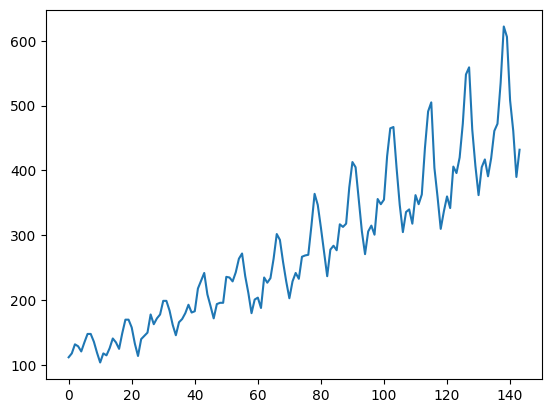

96 48
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 2s - 23ms/step - loss: 0.0616
Epoch 2/100
94/94 - 0s - 2ms/step - loss: 0.0322
Epoch 3/100
94/94 - 0s - 2ms/step - loss: 0.0231
Epoch 4/100
94/94 - 0s - 2ms/step - loss: 0.0203
Epoch 5/100
94/94 - 0s - 3ms/step - loss: 0.0190
Epoch 6/100
94/94 - 0s - 2ms/step - loss: 0.0180
Epoch 7/100
94/94 - 0s - 2ms/step - loss: 0.0171
Epoch 8/100
94/94 - 0s - 2ms/step - loss: 0.0162
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0153
Epoch 10/100
94/94 - 0s - 2ms/step - loss: 0.0144
Epoch 11/100
94/94 - 0s - 2ms/step - loss: 0.0135
Epoch 12/100
94/94 - 0s - 2ms/step - loss: 0.0126
Epoch 13/100
94/94 - 0s - 2ms/step - loss: 0.0117
Epoch 14/100
94/94 - 0s - 2ms/step - loss: 0.0108
Epoch 15/100
94/94 - 0s - 2ms/step - loss: 0.0099
Epoch 16/100
94/94 - 0s - 2ms/step - loss: 0.0090
Epoch 17/100
94/94 - 0s - 2ms/step - loss: 0.0081
Epoch 18/100
94/94 - 0s - 2ms/step - loss: 0.0072
Epoch 19/100
94/94 - 0s - 2ms/step - loss: 0.0064
Epoch 20/100
94/94 - 0s - 2ms/step - loss: 0.0056
Epoch 21/100
94/94 -

In [11]:

import pandas
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


 # reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)



# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train Score: 22.68 RMSE
Test Score: 52.42 RMSE


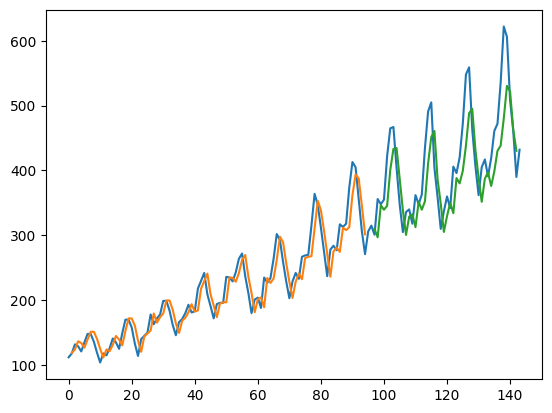

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Start working with dataset


Creating a sample dataset

In [20]:
import pandas as pd


benign_path = "Benign_train.pcap.csv"
attack_path = "TCP_IP-DDoS-TCP2_train.pcap.csv"

benign_df = pd.read_csv(benign_path)
attack_df = pd.read_csv(attack_path)

benign_df["label"] = 0
attack_df["label"] = 1

attack_sample_df = attack_df.sample(n=len(benign_df), random_state=42)

merged_df = pd.concat([benign_df, attack_sample_df], ignore_index=True)

merged_df.to_csv("sample_dataset.csv")

print("Done! dataset saved")

Done! dataset saved


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


data_path = "sample_dataset.csv"

df = pd.read_csv(data_path)

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
print("numberic cols", numeric_cols)

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


df.to_csv("final_dataset.csv")


numberic cols ['Unnamed: 0', 'Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'label']


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class CICIDSLSTMModel:
    """LSTM Model for CIC 2024 Intrusion Detection"""

    def __init__(self, sequence_length=10, n_features=None):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.model = None
        self.history = None

    def prepare_sequences(self, X, y, sequence_length):
        """
        Convert flat data into sequences for LSTM

        Args:
            X: Features array
            y: Labels array
            sequence_length: Number of timesteps in each sequence

        Returns:
            X_seq, y_seq: Sequenced data
        """
        X_seq, y_seq = [], []

        for i in range(len(X) - sequence_length + 1):
            X_seq.append(X[i:i + sequence_length])
            # Use the label of the last timestep in the sequence
            y_seq.append(y[i + sequence_length - 1])

        return np.array(X_seq), np.array(y_seq)

    def build_model(self, learning_rate=0.001):
        """
        Build LSTM architecture
        """
        model = keras.Sequential([
            # First LSTM layer with return sequences
            layers.LSTM(128, return_sequences=True,
                       input_shape=(self.sequence_length, self.n_features),
                       dropout=0.2, recurrent_dropout=0.2),
            layers.BatchNormalization(),

            # Second LSTM layer with return sequences
            layers.LSTM(64, return_sequences=True,
                       dropout=0.2, recurrent_dropout=0.2),
            layers.BatchNormalization(),

            # Third LSTM layer without return sequences
            layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
            layers.BatchNormalization(),

            # Dense layers
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.3),

            # Output layer (binary classification)
            layers.Dense(1, activation='tanh')  # tanh for -1/1 output
        ])

        # Compile model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='mse',  # MSE for -1/1 labels
            metrics=['mae', 'accuracy']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val,
              epochs=50, batch_size=64, class_weight=None):
        """
        Train the model
        """
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_lstm_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        # Train
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """
        Evaluate model performance
        """
        # Predictions
        y_pred_continuous = self.model.predict(X_test).flatten()
        y_pred = np.where(y_pred_continuous > 0, 1, -1)

        # Convert labels to binary for some metrics
        y_test_binary = np.where(y_test > 0, 1, 0)
        y_pred_binary = np.where(y_pred > 0, 1, 0)

        # Metrics
        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred,
                                   target_names=['Normal', 'Attack']))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # ROC-AUC
        auc = roc_auc_score(y_test_binary, y_pred_binary)
        print(f"\nROC-AUC Score: {auc:.4f}")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Attack'],
                   yticklabels=['Normal', 'Attack'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300)
        plt.show()

        return y_pred, y_pred_continuous

    def plot_training_history(self):
        """
        Plot training history
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss
        axes[0].plot(self.history.history['loss'], label='Train Loss')
        axes[0].plot(self.history.history['val_loss'], label='Val Loss')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy
        axes[1].plot(self.history.history['accuracy'], label='Train Accuracy')
        axes[1].plot(self.history.history['val_accuracy'], label='Val Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()


# Usage Example
def main():
    # Load your data
    df = pd.read_csv('cic2024_dataset.csv')

    # Drop unnecessary columns
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Separate features and labels
    X = df.drop('label', axis=1).values
    y = df['label'].values

    print(f"Dataset shape: {X.shape}")
    print(f"Label distribution: {np.unique(y, return_counts=True)}")

    # Split data (80-10-10)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp
    )

    # Create model
    sequence_length = 10
    lstm_model = CICIDSLSTMModel(
        sequence_length=sequence_length,
        n_features=X.shape[1]
    )

    # Prepare sequences
    print("\nCreating sequences...")
    X_train_seq, y_train_seq = lstm_model.prepare_sequences(
        X_train, y_train, sequence_length
    )
    X_val_seq, y_val_seq = lstm_model.prepare_sequences(
        X_val, y_val, sequence_length
    )
    X_test_seq, y_test_seq = lstm_model.prepare_sequences(
        X_test, y_test, sequence_length
    )

    print(f"Training sequences shape: {X_train_seq.shape}")
    print(f"Validation sequences shape: {X_val_seq.shape}")
    print(f"Test sequences shape: {X_test_seq.shape}")

    # Handle class imbalance
    unique, counts = np.unique(y_train_seq, return_counts=True)
    class_weight = {
        -1: len(y_train_seq) / (2 * counts[0]),
        1: len(y_train_seq) / (2 * counts[1])
    }
    print(f"\nClass weights: {class_weight}")

    # Build and train model
    print("\nBuilding model...")
    lstm_model.build_model(learning_rate=0.001)
    lstm_model.model.summary()

    print("\nTraining model...")
    lstm_model.train(
        X_train_seq, y_train_seq,
        X_val_seq, y_val_seq,
        epochs=50,
        batch_size=64,
        class_weight=class_weight
    )

    # Plot training history
    lstm_model.plot_training_history()

    # Evaluate
    print("\nEvaluating on test set...")
    y_pred, y_pred_continuous = lstm_model.evaluate(X_test_seq, y_test_seq)

    # Save model
    lstm_model.model.save('final_lstm_model.h5')
    print("\nModel saved as 'final_lstm_model.h5'")


if __name__ == "__main__":
    main()
